# LinuxForHealth (LFH) - Pulse Demo

In [ ]:
# INSTRUCTIONS
# 1. Set the Raspberry Pi and LinuxONE hosts at the bottom of this cell
# 2. Run all of the cells
# 3. Demonstrate the function via the UI widgets

import requests
import json
import pandas as pd
import base64
from requests.auth import HTTPBasicAuth
from IPython.display import Image, display
from IPython.core.display import HTML
from ipywidgets import Dropdown, Text, Layout, FileUpload, Button, Output

# Set Raspberry Pi and LinuxOne hosts
pi_host="0.0.0.0"
linuxONE_host="0.0.0.0"

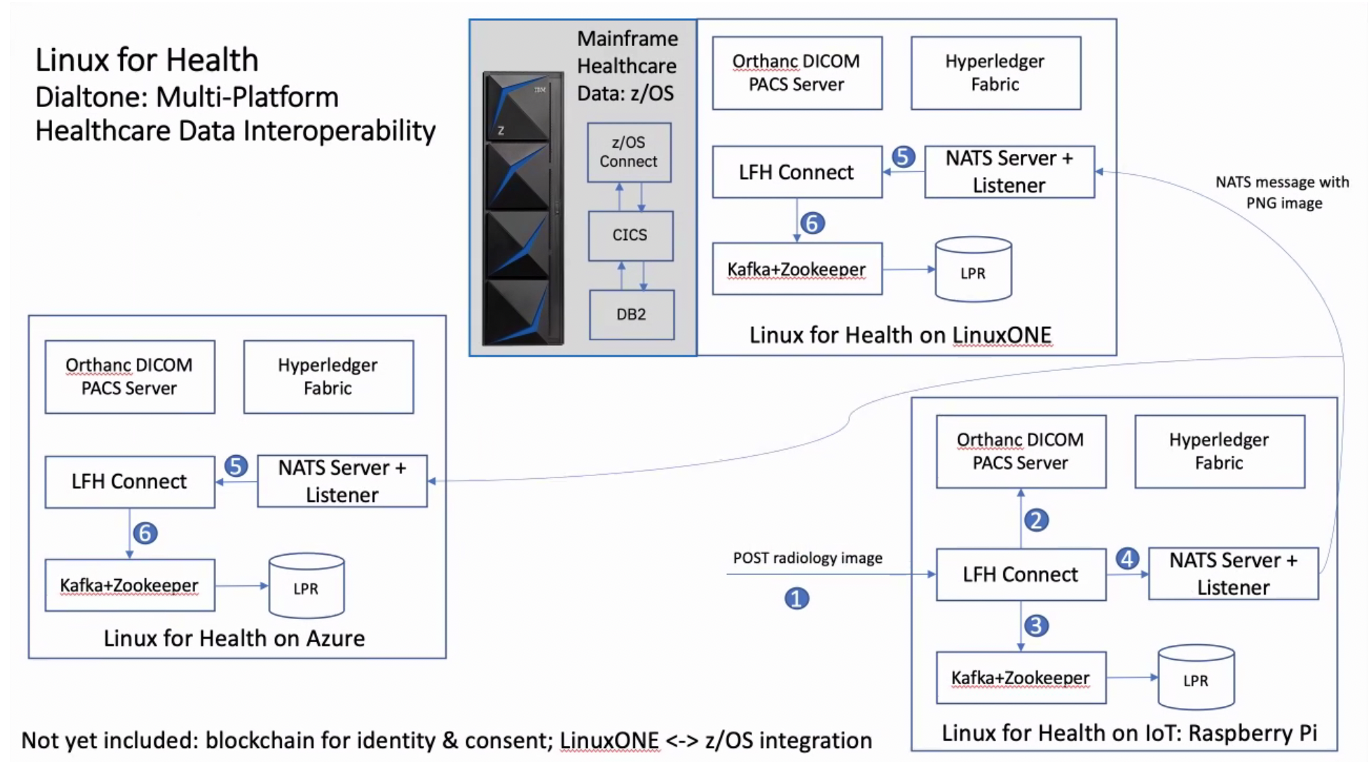

---

### Demonstrate sending a DICOM image to a Raspberry Pi device and retrieving it from LinuxONE via LFH

In [ ]:
uuid=None

def handle_send(button):
    global uuid
    with w_output:
        print("Sending ...")
    
    dicom_file = w_file_upload.value[w_file_upload.metadata[0]['name']]['content']

    resp = requests.post(w_post_endpoint_text.value, auth=HTTPBasicAuth('orthanc','orthanc'), data=dicom_file, verify=False)

    if resp.ok:
        json_data = resp.json()
        
        uuid = json_data['meta']['uuid']
        
        w_output.clear_output()
        with w_output:
            print("File successfully sent, returned uuid =", uuid)
            
        w_button_get.layout=Layout(visibility='visible')
        w_get_endpoint_text.layout=Layout(width='60%', visibility='visible')
        
    else:
        with w_output:
            w_output.clear_output()
            print("Error occurred sending file, code: ", resp.status_code, " body:\n", resp.text)
        
def image_formatter(im):
        return f'<img src="data:image/jpeg;base64,{im}">'        

def handle_get(button):
    global uuid
    with w_output_get:
        print("Retrieving images from LinuxONE")
        
    resp = requests.get(w_get_endpoint_text.value, headers={"accept":"application/json"}, verify=False)

    if resp.ok:
    
        json_data = resp.json()

        my_df = []

        for i in json_data:
            msg = i['message']
            msg_json = json.loads(msg)
            if uuid != msg_json['meta']['uuid']:
                continue
            data = msg_json['data']
            dec_data = base64.b64decode(data).decode('utf-8')
            img_json = json.loads(dec_data)
            image_str = base64.b64decode(img_json['image'])
            my_df.append([ msg_json['meta']['routeId'], msg_json['meta']['uuid'], img_json['image'] ])

        my_df = pd.DataFrame(my_df, columns=['Route ID', 'UUID', 'Image'])

        w_output_get.clear_output()
        with w_output_get:
            if my_df.empty:
                print("Response was successful, but no image found matching uuid: ", uuid)
                return
            print("Image successfully retrieved")
            display(HTML(my_df.to_html(formatters={'Image': image_formatter}, escape=False)))
            
    else:
        w_output_get.clear_output()
        with w_output_get:
            print("Error occurred retrieving file, code: ", resp.status_code, " body:\n", resp.text)
    
def file_selection(change):
    w_button.layout=Layout(visibility='visible')
    
post_endpoint = "http://" + pi_host + ":8080/orthanc/instances"
get_endpoint = "http://" + linuxONE_host + ":9000/topic/DICOM_IMAGE/messages?partition=0&offset=0&count=100&keyFormat=DEFAULT&format=DEFAULT"

# Widget FileUpload
w_file_upload = FileUpload(
    description="Select Image File",
    multiple=False,
    layout=Layout(width="200px")
)
w_file_upload.observe(file_selection)

# Widget Text
w_post_endpoint_text = Text(
    value=post_endpoint,
    placeholder='Enter post endpoint url',
    description='Post Endpoint:',
    disabled=False,
    layout=Layout(width='60%'),
    style={'description_width': '130px'}
)

# Widget Text
w_get_endpoint_text = Text(
    value=get_endpoint,
    placeholder='Enter get endpoint url',
    description='Retrieval Endpoint:',
    disabled=False,
    layout=Layout(visibility='hidden'),
    style={'description_width': '130px'}
)

# Widget Output
w_output = Output()
w_output_get = Output()

# Widget Button
w_button = Button(description="Send File", layout=Layout(visibility='hidden'))
w_button.on_click(handle_send)

# Widget Button
w_button_get = Button(description="Retrieve File", layout=Layout(visibility='hidden'))
w_button_get.on_click(handle_get)

# Render UI
print("\nSelect DICOM image file for upload:\n")
display(w_file_upload)
display(w_post_endpoint_text)
display(w_button)
display(w_output)
display(w_get_endpoint_text)
display(w_button_get)
display(w_output_get)